CS230 Final Project | Madison Hall & Jackie Ennis

CNN's for Multi-class Classification of Plant Seedling Images

# LOAD IN DATA
Import packages.

In [1]:
import os
import numpy as np
import time
import random
import matplotlib.pyplot as plt
import collections
import operator

import cv2
from scipy import ndarray
import skimage as sk
from skimage import color, io, transform, util
from sklearn.preprocessing import MinMaxScaler
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix, recall_score, precision_recall_fscore_support
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow import keras
import seaborn as sns

from keras import layers, models, optimizers, Sequential
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import VGG16
from keras.applications.densenet import DenseNet121
from keras.callbacks import Callback


Using TensorFlow backend.


Define data augmentation helper functions.

In [2]:
# add random noise to the image
def random_noise(image_array):
    # add random noise to the image
    new_img = sk.util.random_noise(image_array, 
                              mode='poisson')
    return new_img
    
# flip 
def horizontal_flip(image_array):
    new_img = image_array[:, ::-1]
    return new_img

def vertical_flip(image_array):
    new_img = image_array[::-1, :]
    return new_img

def augment(image):
    # Randomly pick two transformations to perform
    aug_choices = random.sample(range(0,3), 2)
    edited = image
  
    # Apply multiple transformations associated with numbers drawn to the same image
    for choice in aug_choices:
        if choice == 0:
            edited = random_rotation(edited)
            # print("Rotated image.")
        if choice == 1:
            edited = horizontal_flip(edited)
            # print("Horizontally flipped image.")
        if choice == 2:
            edited = vertical_flip(edited)
            # print("Vertically flipped image.")
    
    return edited

Load image data from train and test folders. 

In [3]:
# Local paths to data
TRAIN_DIR = "./jackie/train"
TEST_DIR = "./jackie/test"

# Mapping species names to numerical label equivalent
class_labels = {
               'Black-grass': 0,
               'Charlock': 1,
               'Cleavers': 2,
               'Common Chickweed': 3,
               'Common wheat': 4,
               'Fat Hen': 5,
               'Loose Silky-bent': 6,
               'Maize': 7,
               'Scentless Mayweed': 8,
               'Shepherd': 9,
               'Small-flowered Cranesbill': 10,
               'Sugar beet': 11
              }

# Creates class label for image based on filename 
def createLabel(fname):
    for species, number in class_labels.items():
        if species in fname:
            return number
    
    print("No name found for ", fname)
    return 12

def load_data(dirname):
    data = []
    labels = []
    class_count = np.zeros(12)
    
    for fname in os.listdir(dirname):
        path = os.path.join(dirname, fname)
        img = cv2.imread(path)
        lab = createLabel(fname)
        
        if class_count[lab] <= 1000:      
            data.append(horizontal_flip(img))
            labels.append(lab)
            
            data.append(vertical_flip(img))
            labels.append(lab)
            
            data.append(vertical_flip(horizontal_flip(img)))
            labels.append(lab)
            
            class_count[lab] += 3
            
        data.append(img)
        labels.append(lab)
        class_count[lab] += 1
        
        max_class = max(class_count)
        
    return np.array(data), labels

trainImages, trainLabels = load_data(TRAIN_DIR)
testImages, testLabels = load_data(TEST_DIR)

In [4]:
# Sanity check
print(trainImages.shape, len(trainLabels), 
     testImages.shape, len(testLabels))

(13120, 64, 64, 3) 13120 (4428, 64, 64, 3) 4428


In [5]:
# Check class sizes after augmentation
collections.Counter(trainLabels)

Counter({8: 1237,
         3: 1332,
         6: 1377,
         11: 1116,
         10: 1211,
         0: 980,
         1: 1108,
         7: 828,
         2: 1017,
         4: 840,
         5: 1170,
         9: 904})

# DATA PREPROCESSING
Easy image visualization.

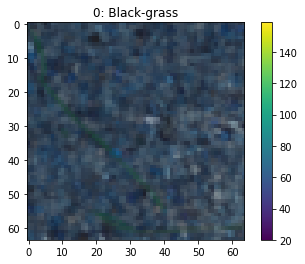

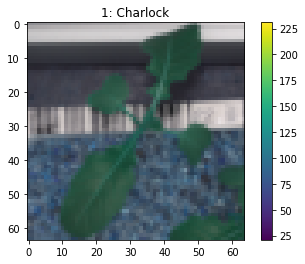

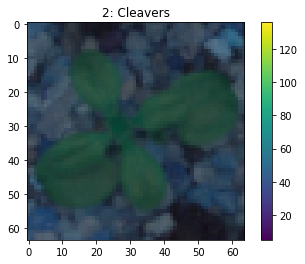

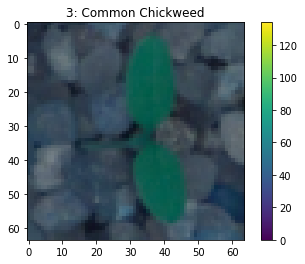

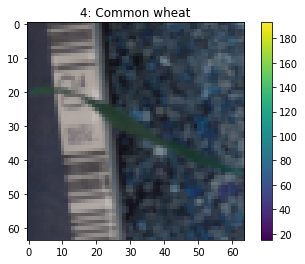

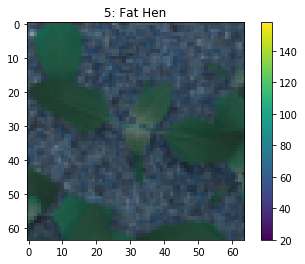

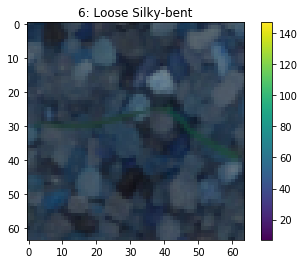

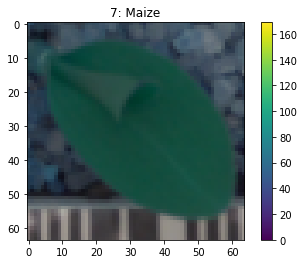

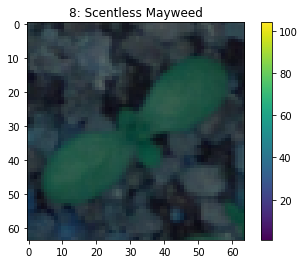

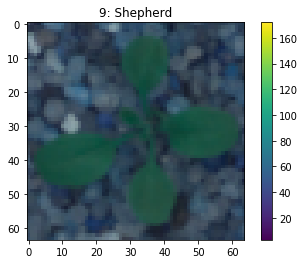

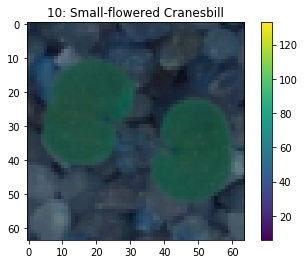

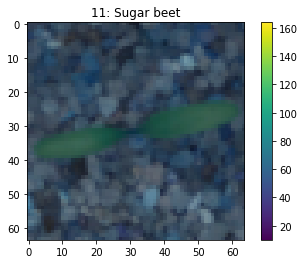

In [6]:
# Mapping numerical label to species name
label_to_species = ['Black-grass','Charlock',
                        'Cleavers','Common Chickweed',
                        'Common wheat', 'Fat Hen',
                        'Loose Silky-bent','Maize',
                        'Scentless Mayweed',
                        'Shepherd','Small-flowered Cranesbill',
                        'Sugar beet']

# finds first example of species in given data
def visualizeExample(train, label, species):
    # Index of first example of species in training data
    i = label.index(species)

    plt.figure()
    # Include word label in title
    title = str(label[i]) + ": " + label_to_species[species]
    plt.title(title)
    plt.imshow(train[i])
    plt.colorbar()
    plt.grid(False)
    plt.show()
    
for seed in range(0, 12):
    visualizeExample(trainImages, trainLabels, seed)
    

## Normalization
Scale the values to be between 0 and 1.

In [7]:
# Normalize data by scaling down to [0, 1] range
def normalize_0_1(images):
    # Make copy to avoid overwriting
    images_copy = np.copy(images)
    
    # Get original shape
    n_samples, width, height, n_channels = images.shape
    channel_layers = []

    # For each channel in RGB, normalize the pixels
    for i in range(0, 3):
        # Get channel slice and flatten to dim-2
        channel = images_copy[:, :, :, i]
        channel = channel.reshape((n_samples, width*height))

        # Scale data across channel
        min_max_scaler = MinMaxScaler()
        channel_normed = min_max_scaler.fit_transform(channel)
        channel_normed = channel_normed.reshape((n_samples, width, height))

        # Add to list of channels to be stacked back together 
        channel_layers.append(channel_normed)

    images_normalized = np.stack(channel_layers, axis=3)
    return images_normalized


Another technique for normalization, which we tried but led to worse performance. 

In [8]:
# Normalize data by subtracting the mean and dividing by the standard deviation
def normalize_subtract_mean(images):
    N, W, H, n_channels = images.shape
    images = images.astype(np.float32, casting="same_kind")
    
    # center the data
    for i in range(n_channels):
        images[:, :, :, i] -= np.mean(images[:, :, :, i])
        
    # normalize the data
    pixels = images.reshape(N, -1)
    for i in range(pixels.shape[1]):
        pixels[:, i] /= np.std(pixels[:, i])
    
    return pixels.reshape(N, W, H, n_channels)

In [9]:
# Get arrays to use for rest of model training and test
trainImages_normed = normalize_0_1(trainImages)
testImages_normed = normalize_0_1(testImages)

trainImages_normed, trainLabels = shuffle(trainImages_normed, trainLabels)
testImages_normed, testLabels = shuffle(testImages_normed, testLabels)


# Change labels into one-hot categorical encoding
trainLabels_onehot = keras.utils.to_categorical(trainLabels)
testLabels_onehot = keras.utils.to_categorical(testLabels)

/home/john_kamalu/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/home/john_kamalu/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/home/john_kamalu/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/home/john_kamalu/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/home/john_kamalu/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: Da

[0.18072289 0.1625     0.23175966]


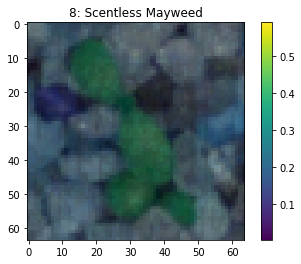

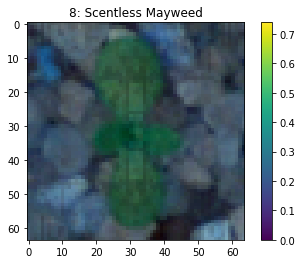

In [10]:
# Sanity check
print(trainImages_normed[0][0][0])
visualizeExample(trainImages_normed, trainLabels, 8)
visualizeExample(testImages_normed, testLabels, 8)

# MODELS

## Training functions

In [11]:
# Shape of images to be fed into models
input_shape = (64, 64, 3)

# Freeze a specified number of layers of a (pre-trained) model
def freeze_layers(model, layers_to_freeze):
    for layer in model.layers:
        layer.trainable = True

    for layer in model.layers[:-layers_to_freeze]:
        layer.trainable = False

    # Check the trainable status of the individual layers
    for layer in model.layers:
        print(layer, layer.trainable)

In [12]:
# Compute weighted class weights from labels
class_weights = compute_class_weight('balanced', np.unique(trainLabels), trainLabels)
class_weights = dict(enumerate(class_weights))

# Print confusion matrix during training for debugging
class ConfusionCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if epoch % 5 == 0:
            x_test = self.validation_data[0]
            y_test = self.validation_data[1]

            predictions = self.model.predict(x_test)
            y_test = np.argmax(y_test, axis=-1)
            predictions = np.argmax(predictions, axis=-1)
            c = confusion_matrix(y_test, predictions)

            print('Confusion matrix:\n', c)

In [13]:
# Fit a model to given data; returns history
# Call only after building and compiling; will begin training on specified number of epochs
def fit_model(model, train, labels, n_epochs=20):
    start_time = time.time()
    history = model.fit(train, 
                        labels, 
                        validation_split=0.10, 
                        epochs=n_epochs,
                        batch_size=32, 
                        class_weight=class_weights)
    end_time = time.time() - start_time

    print("Total time elapsed:", end_time)
    return history

# pring conf matrix for debugging: callbacks=[ConfusionCallback()]


## CNN Baseline Model

In [14]:
# Compile architecture of baseline CNN model
def build_cnn():
    cnn_model = keras.Sequential([
        keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
        keras.layers.Dropout(0.1),
        keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Dropout(0.1),
        keras.layers.Flatten(),
        keras.layers.Dense(12, activation='softmax')
    ])
    
    cnn_model.compile(optimizer='adam', 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return cnn_model

In [15]:
# Train CNN model on normalized training data
cnn_model = build_cnn()
start_time = time.time()
cnn_history = fit_model(cnn_model, trainImages_normed, 
                        trainLabels_onehot)
cnn_duration = time.time() - start_time

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Train on 11808 samples, validate on 1312 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/20
11808/11808 [==============================] - 30s 3ms/sample - loss: 1.3522 - acc: 0.5233 - val_loss: 1.0083 - val_acc: 0.6593
Epoch 2/20
11808/11808 [==============================] - 7s 593us/sample - loss: 0.8555 - acc: 0.7181 - val_loss: 0.8321 - val_acc: 0.7241
Epoch 3/20
11808/11808 [==============================] - 7s 593us/sample - loss: 0.6148 - acc: 0.7984 - val_loss: 0.7689 - val_acc: 0.7363
Epoch 4/20
11808/11808 [==============================] - 7s 593us/sample - loss: 0.4394 - acc: 0.8598 - val_loss: 0.7868 - val_acc: 0.7287
Epoch 5/20
11808/11808 [==============================] - 7s 594us/sample - loss: 0.3106 - acc: 0.9025 - val_loss: 0.6938 - val_acc: 0.7660
Epoch 6/20
11808/

## Pre-trained model: DenseNet121

In [16]:
print(1)

1


In [17]:
# Load the DenseNet121 model
densenet = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)

In [18]:
# Add Densenet121 model as base and define remaining architecture
def build_densenet(n_freeze_layers, dropout_rate=0.4):
    # Create the model
    model = models.Sequential()

    # Add the densenet base model
    model.add(densenet)

    # Freeze layers
    freeze_layers(densenet, n_freeze_layers)

    # Add new layers
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(12, activation='softmax'))

    # Compile the model
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])
    
    return model

In [19]:
# Train DenseNet model on normalized training data
densenet_model = build_densenet(n_freeze_layers=1)
start_time = time.time()
densenet_history = fit_model(densenet_model, 
                            trainImages_normed, 
                            trainLabels_onehot)
densenet_duration = time.time() - start_time

<keras.engine.input_layer.InputLayer object at 0x7f4e714e6cc0> False
<keras.layers.convolutional.ZeroPadding2D object at 0x7f4e714e6048> False
<keras.layers.convolutional.Conv2D object at 0x7f4e5a941e48> False
<keras.layers.normalization.BatchNormalization object at 0x7f4e5a9cbda0> False
<keras.layers.core.Activation object at 0x7f4e3bd8c908> False
<keras.layers.convolutional.ZeroPadding2D object at 0x7f4e3bdb1eb8> False
<keras.layers.pooling.MaxPooling2D object at 0x7f4ef9ddb780> False
<keras.layers.normalization.BatchNormalization object at 0x7f4ef9dc18d0> False
<keras.layers.core.Activation object at 0x7f4ef9d01be0> False
<keras.layers.convolutional.Conv2D object at 0x7f4e5a9d8da0> False
<keras.layers.normalization.BatchNormalization object at 0x7f4e5a8501d0> False
<keras.layers.core.Activation object at 0x7f4e72180128> False
<keras.layers.convolutional.Conv2D object at 0x7f4e71570358> False
<keras.layers.merge.Concatenate object at 0x7f4e5a9156a0> False
<keras.layers.normalization.

Train on 11808 samples, validate on 1312 samples
Epoch 1/20
11808/11808 [==============================] - 33s 3ms/step - loss: 2.0968 - acc: 0.2708 - val_loss: 1.4665 - val_acc: 0.5046
Epoch 2/20
11808/11808 [==============================] - 22s 2ms/step - loss: 1.6896 - acc: 0.4006 - val_loss: 1.3327 - val_acc: 0.5480
Epoch 3/20
11808/11808 [==============================] - 23s 2ms/step - loss: 1.5464 - acc: 0.4469 - val_loss: 1.2496 - val_acc: 0.5526
Epoch 4/20
11808/11808 [==============================] - 22s 2ms/step - loss: 1.4854 - acc: 0.4673 - val_loss: 1.1929 - val_acc: 0.5945
Epoch 5/20
11808/11808 [==============================] - 22s 2ms/step - loss: 1.4393 - acc: 0.4758 - val_loss: 1.1555 - val_acc: 0.5785
Epoch 6/20
11808/11808 [==============================] - 22s 2ms/step - loss: 1.3884 - acc: 0.4944 - val_loss: 1.1547 - val_acc: 0.5899
Epoch 7/20
11808/11808 [==============================] - 22s 2ms/step - loss: 1.3859 - acc: 0.4975 - val_loss: 1.1331 - val_acc:

In [20]:
# Load the VGG16 model
vgg = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

In [21]:
# Add VGG16 model as base and define remaining architecture
def build_vgg(n_freeze_layers, dropout_rate=0.4):
    # Create the model
    model = models.Sequential()

    # Add the densenet base model
    model.add(vgg)

    # Freeze layers
    freeze_layers(vgg, n_freeze_layers)

    # Add new layers
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(12, activation='softmax'))

    # Compile the model
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])

    # Show a summary of the model. Check the number of trainable parameters
    model.summary()
    
    return model

In [22]:
# Train VGG model on normalized training data
vgg_model = build_vgg(n_freeze_layers=1)
start_time = time.time()
vgg_history = fit_model(vgg_model, trainImages_normed, trainLabels_onehot)
duration_vgg = time.time() - start_time

<keras.engine.input_layer.InputLayer object at 0x7f4a80d8c400> False
<keras.layers.convolutional.Conv2D object at 0x7f4a81174a90> False
<keras.layers.convolutional.Conv2D object at 0x7f4a81174160> False
<keras.layers.pooling.MaxPooling2D object at 0x7f4a45a694e0> False
<keras.layers.convolutional.Conv2D object at 0x7f4a45a692b0> False
<keras.layers.convolutional.Conv2D object at 0x7f4a459874e0> False
<keras.layers.pooling.MaxPooling2D object at 0x7f4a4597f400> False
<keras.layers.convolutional.Conv2D object at 0x7f4a4596a438> False
<keras.layers.convolutional.Conv2D object at 0x7f4a4589dac8> False
<keras.layers.convolutional.Conv2D object at 0x7f4a45828400> False
<keras.layers.pooling.MaxPooling2D object at 0x7f4a4578c630> False
<keras.layers.convolutional.Conv2D object at 0x7f4a457a1860> False
<keras.layers.convolutional.Conv2D object at 0x7f4a4573e828> False
<keras.layers.convolutional.Conv2D object at 0x7f4a456b6828> False
<keras.layers.pooling.MaxPooling2D object at 0x7f4a455c3390>

In [ ]:
# Load the ResNet50 model
resnet = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

In [24]:
# Add ResNet50 model as base and define remaining architecture
def build_resnet(n_freeze_layers=1, dropout_rate=0.4):
    # Create the model
    model = models.Sequential()

    # Add the resnet base model
    model.add(resnet)

    # Freeze layers
    freeze_layers(resnet, n_freeze_layers)

    # Add new layers
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(12, activation='softmax'))

    # Compile the model
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])

    # Show a summary of the model. Check the number of trainable parameters
    model.summary()
    
    return model

In [25]:
# Train ResNet model on normalized training data
resnet_model = build_resnet(n_freeze_layers=1)
start_time = time.time()
resnet_history = fit_model(resnet_model, trainImages_normed, trainLabels_onehot)
duration_resnet = time.time() - start_time

<keras.engine.input_layer.InputLayer object at 0x7f4a453b9630> False
<keras.layers.convolutional.ZeroPadding2D object at 0x7f4a453b9320> False
<keras.layers.convolutional.Conv2D object at 0x7f4a453b9c18> False
<keras.layers.normalization.BatchNormalization object at 0x7f4a44e32518> False
<keras.layers.core.Activation object at 0x7f4a44dc83c8> False
<keras.layers.convolutional.ZeroPadding2D object at 0x7f4a44e102e8> False
<keras.layers.pooling.MaxPooling2D object at 0x7f4a44e10358> False
<keras.layers.convolutional.Conv2D object at 0x7f4a44cd4978> False
<keras.layers.normalization.BatchNormalization object at 0x7f4a44cfa080> False
<keras.layers.core.Activation object at 0x7f4a44cfaa58> False
<keras.layers.convolutional.Conv2D object at 0x7f4a44d31470> False
<keras.layers.normalization.BatchNormalization object at 0x7f4a44cb8c50> False
<keras.layers.core.Activation object at 0x7f4a44c36d30> False
<keras.layers.convolutional.Conv2D object at 0x7f4a44b09e80> False
<keras.layers.convolution

Train on 11808 samples, validate on 1312 samples
Epoch 1/20
11808/11808 [==============================] - 22s 2ms/step - loss: 2.0098 - acc: 0.3222 - val_loss: 1.4458 - val_acc: 0.4718
Epoch 2/20
11808/11808 [==============================] - 13s 1ms/step - loss: 1.5561 - acc: 0.4511 - val_loss: 1.2960 - val_acc: 0.5274
Epoch 3/20
11808/11808 [==============================] - 13s 1ms/step - loss: 1.3657 - acc: 0.5160 - val_loss: 1.2177 - val_acc: 0.5595
Epoch 4/20
11808/11808 [==============================] - 13s 1ms/step - loss: 1.2485 - acc: 0.5514 - val_loss: 1.1712 - val_acc: 0.5610
Epoch 5/20
11808/11808 [==============================] - 13s 1ms/step - loss: 1.1564 - acc: 0.5916 - val_loss: 1.1629 - val_acc: 0.5869
Epoch 6/20
11808/11808 [==============================] - 13s 1ms/step - loss: 1.1034 - acc: 0.6095 - val_loss: 1.2103 - val_acc: 0.5808
Epoch 7/20
11808/11808 [==============================] - 13s 1ms/step - loss: 1.0311 - acc: 0.6252 - val_loss: 1.1282 - val_acc:

# EVALUATION
Helpful functions for evaluating the performance of a model using metrics like:
- F1 score (our main evaluation metric)
- Test accuracy
- Precision and recall

We also visualize some plots, like the confusion matrix and the loss / test accuracy over training time.

In [27]:
# Returns a model's predictions on some dataset
def get_predictions(model, data):
    predict_probs = model.predict(data)
    predict_labels = []
    
    for i in range(len(predict_probs)):
        guess = np.argmax(predict_probs[i])
        predict_labels.append(guess)
        
    return predict_labels

In [28]:
# Plot validation accuracy vs. number of training epochs
def plot_performance(history, title):
    # Plot training & validation accuracy values
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model accuracy for ' + title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss for ' + title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

In [29]:
# Prints and returns test accuracy of model on given test set (use one hot encoded labels)
def evaluate_test_accuracy(model, test, true_labels):
    test_loss, test_acc = model.evaluate(test, true_labels)
    print("Test Accuracy: ", test_acc)

#     predict_probs = model.predict(test)
#     predict_labels = []
#     for i in range(len(predict_probs)):
#         guess = np.argmax(predict_probs[i])
#         predict_labels.append(guess)
        
    # print(metrics.classification_report(true_labels, predict_labels, target_names=class_labels))
    
    return test_acc

In [30]:
# Prints and returns precision, recall, and fscore of model on given test set (use one hot encoded labels)
def evaluate_f1(model, test, true_labels):
    predict_probs = model.predict(test)
    predict_labels = []
    for i in range(len(predict_probs)):
        guess = np.argmax(predict_probs[i])
        predict_labels.append(guess)
    
    scores = precision_recall_fscore_support(true_labels, predict_labels, average='weighted')
    print("Precision, recall, f1 score:", scores)
    return scores

In [31]:
# Print confusion matrix of model (use categorical labels)
def print_conf_matrix(model, train, labels, title):
    conf_mat = metrics.confusion_matrix(labels, np.argmax(model.predict(train), axis=1))
    fig, ax = plt.subplots(figsize=(12,12))
    sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=list(class_labels.keys()), yticklabels=list(class_labels.keys()))
    plt.title('Confusion matrix for ' + title)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

In [32]:
# Get indices of all misclassified examples in the test set (use original categorical labels)
def get_misclassifications(model, test_data, true_labels):
    predictions = get_predictions(model, test_data)
    misses = []
    for i in range(len(predictions)):
        if predictions[i] != true_labels[i]:
            misses.append(i)
    return misses
    

In [33]:
# Visualize a misclassified example (use original categorical labels)
def show_misclassification_examples(model, test_data, true_labels, n):
    misses = get_misclassifications(model, test_data, true_labels)
    predictions = get_predictions(model, test_data)
    
    for rep in range(n):
        example = random.choice(misses)
        
        false_class = label_to_species[predictions[example]]
        true_class = label_to_species[testLabels[example]]

        plt.figure()
        plt.title("Predicted label: " + false_class
                  + "\n True label: " + true_class)
        plt.imshow(testImages_normed[example])
        plt.colorbar()
        plt.grid(False)
        plt.show()
    

## Evaluate models' performances
Evaluate performance of all 4 models on metrics / plots outlined above.

========================== RESULTS FOR Baseline CNN ==========================


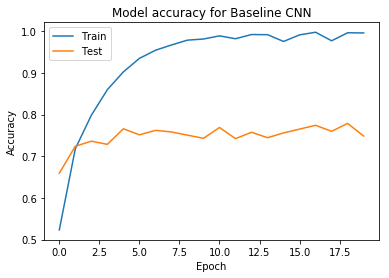

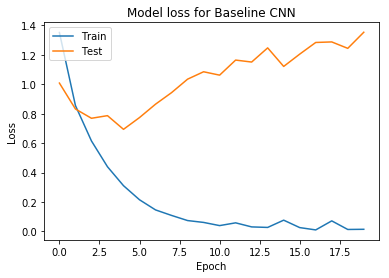

4428/4428 [==============================] - 2s 379us/sample - loss: 1.3787 - acc: 0.7572
Test Accuracy:  0.75722677
Precision, recall, f1 score: (0.7748169381852429, 0.757226738934056, 0.7581464077487688, None)


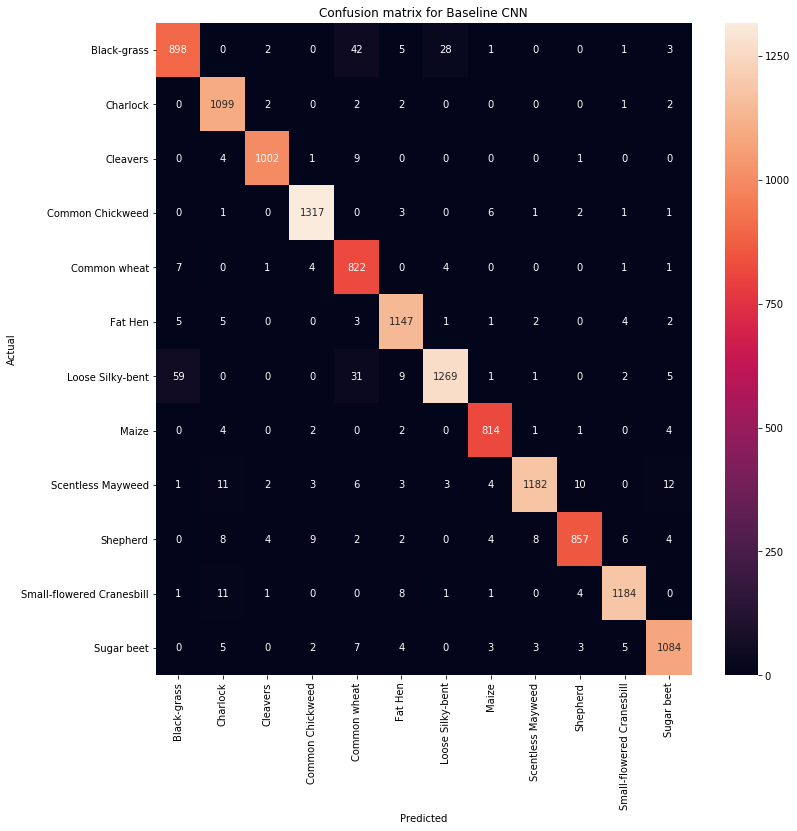

Misclassified examples for  Baseline CNN


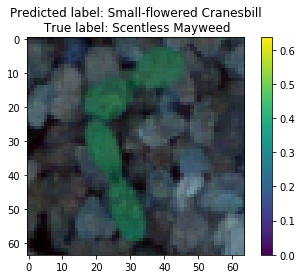

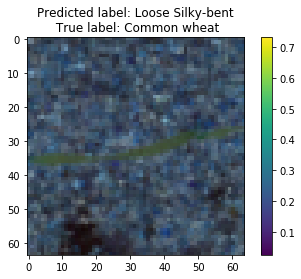

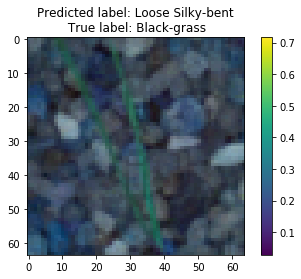

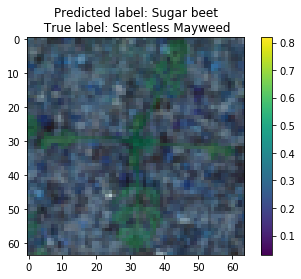

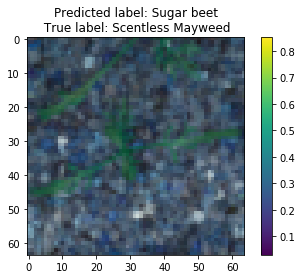

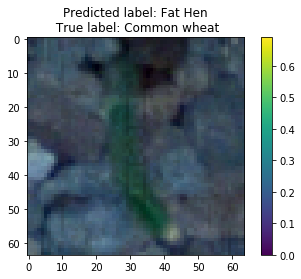

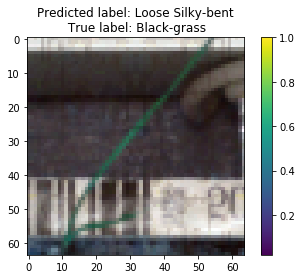

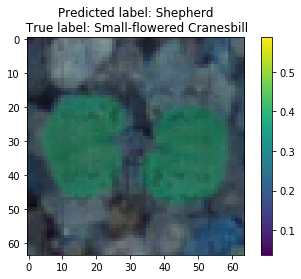

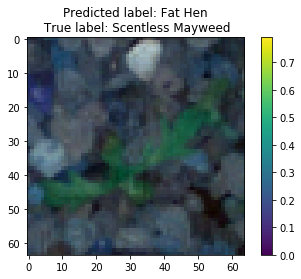

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


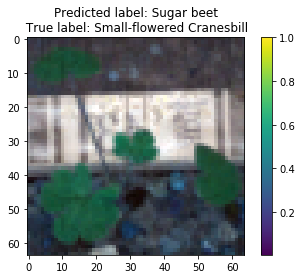

========================== RESULTS FOR DenseNet121 ==========================


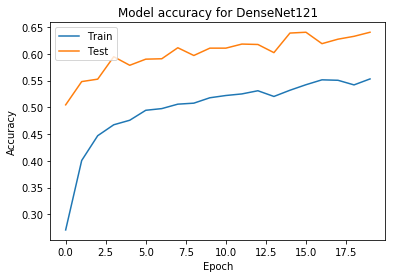

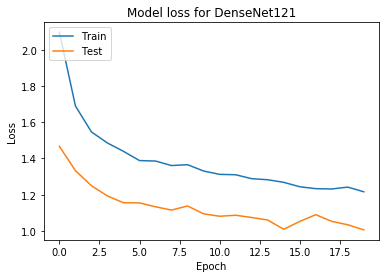

4428/4428 [==============================] - 10s 2ms/step
Test Accuracy:  0.5919150858175248
Precision, recall, f1 score: (0.604714191114486, 0.5919150858175248, 0.5881616106829715, None)


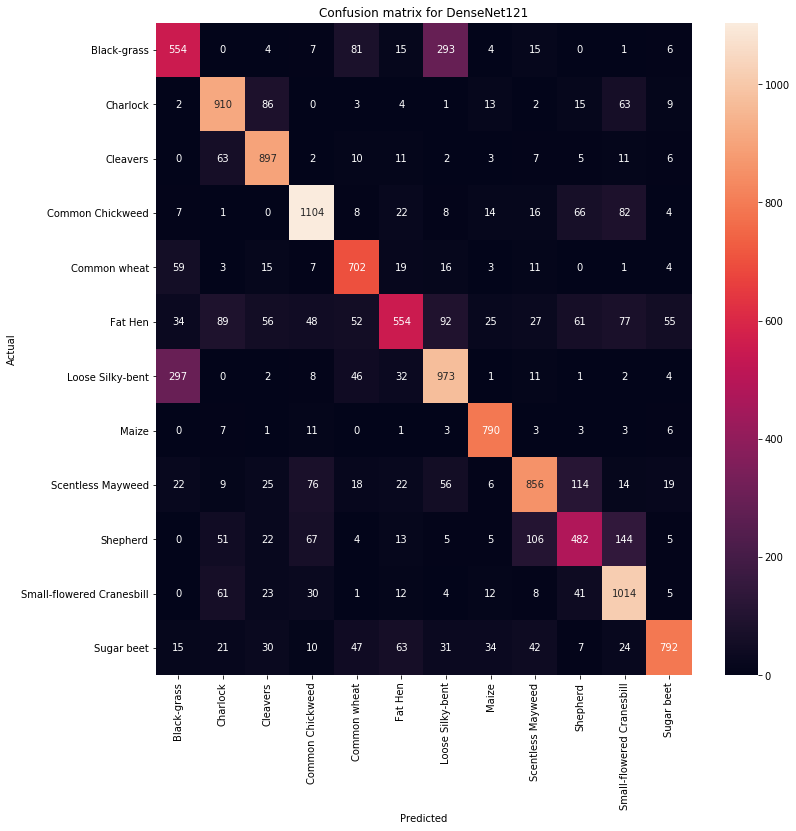

Misclassified examples for  DenseNet121


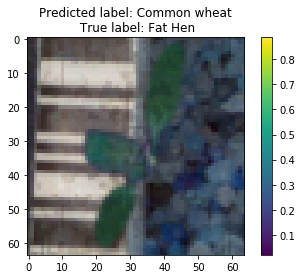

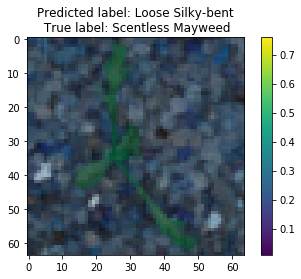

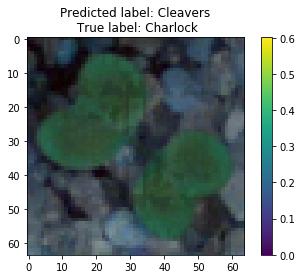

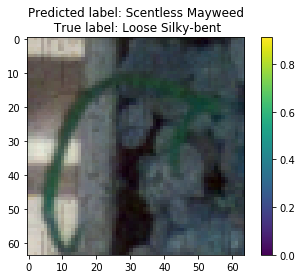

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


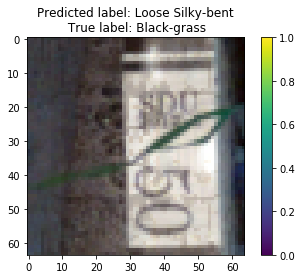

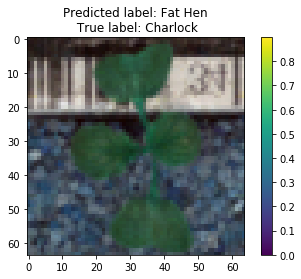

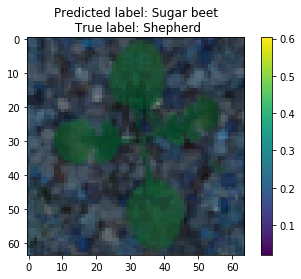

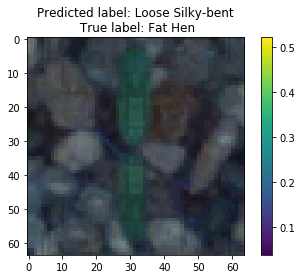

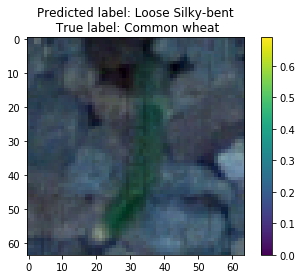

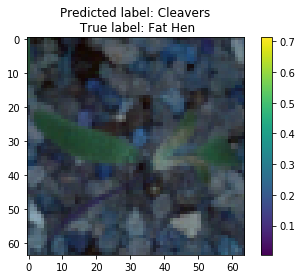

========================== RESULTS FOR VGG16 ==========================


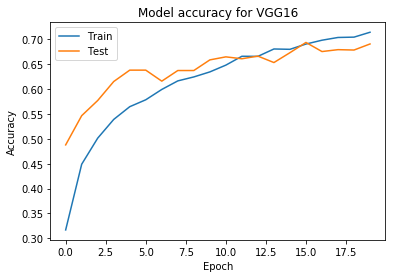

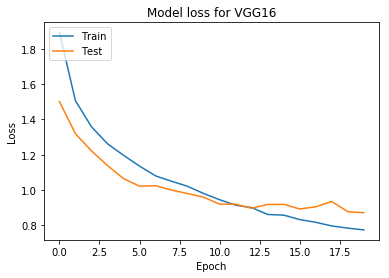

4428/4428 [==============================] - 3s 755us/step
Test Accuracy:  0.6456639566934098
Precision, recall, f1 score: (0.6743936784763009, 0.6456639566395664, 0.6528153810502721, None)


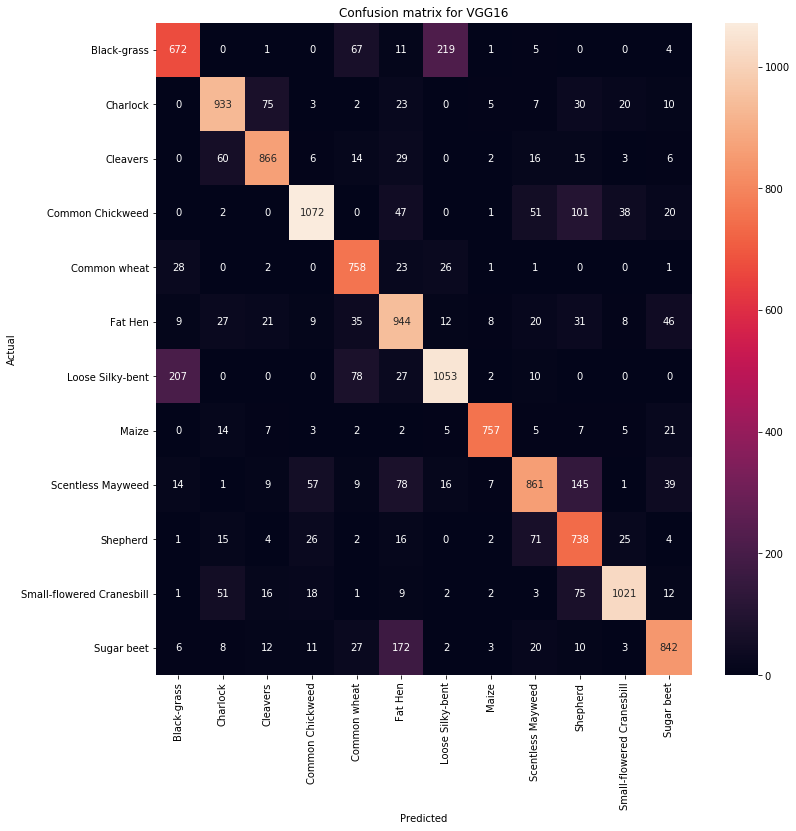

Misclassified examples for  VGG16


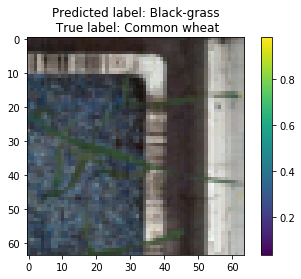

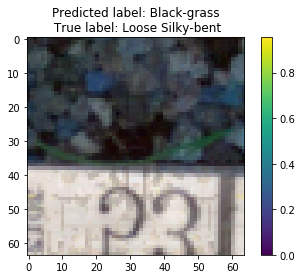

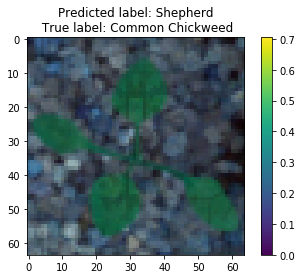

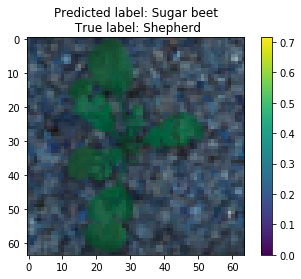

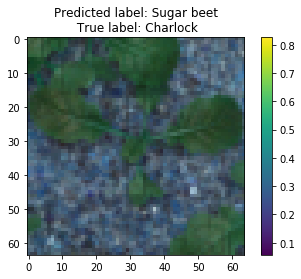

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


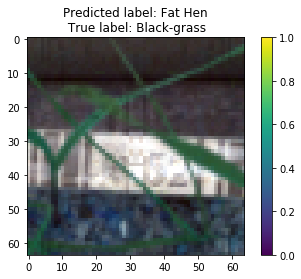

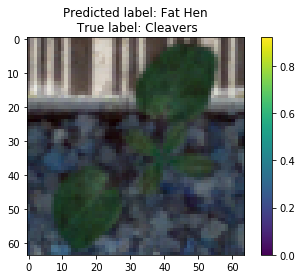

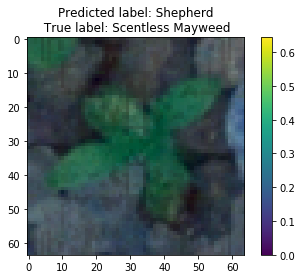

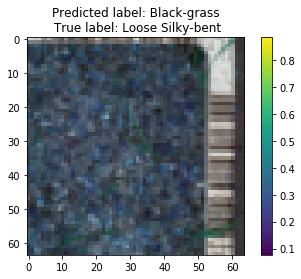

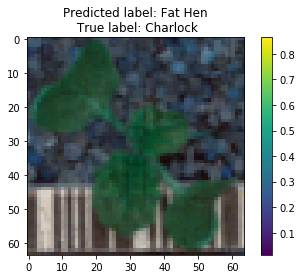

========================== RESULTS FOR ResNet50 ==========================


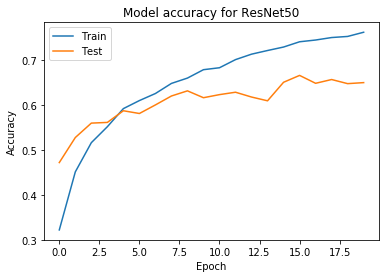

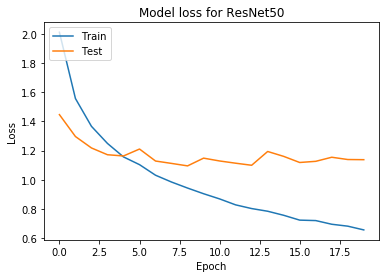

4428/4428 [==============================] - 4s 938us/step
Test Accuracy:  0.5580397470102939
Precision, recall, f1 score: (0.5822942463963726, 0.5580397470641373, 0.561489875439951, None)


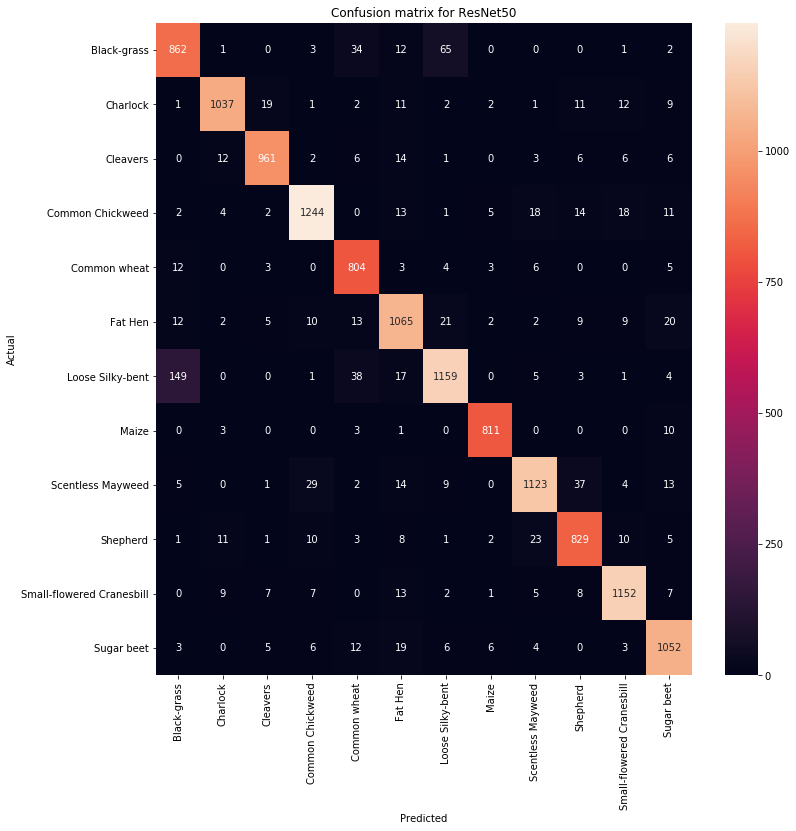

Misclassified examples for  ResNet50


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


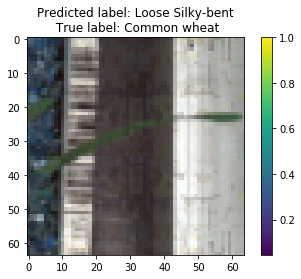

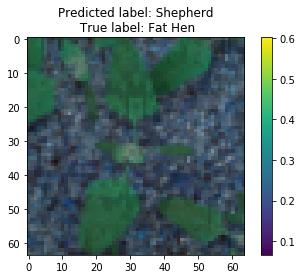

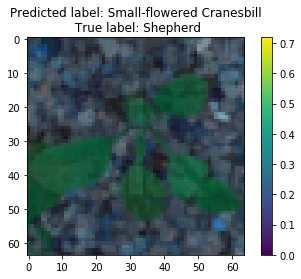

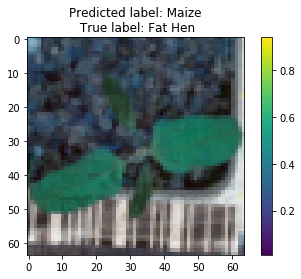

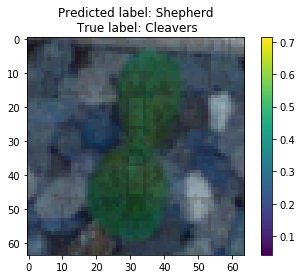

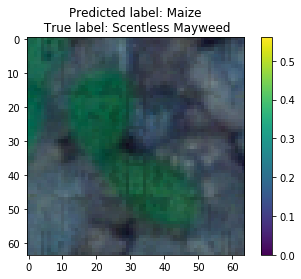

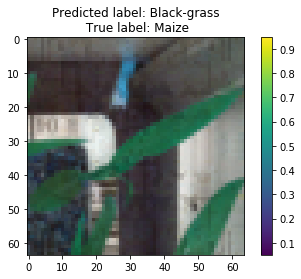

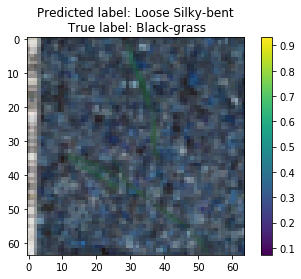

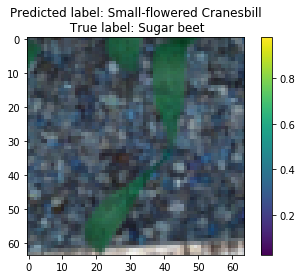

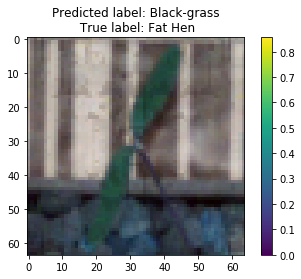

In [34]:
all_models= [("Baseline CNN", cnn_model, cnn_history),
          ("DenseNet121", densenet_model, densenet_history),
          ("VGG16", vgg_model, vgg_history),
          ("ResNet50", resnet_model, resnet_history)]

for title, model, history in all_models:
    print("========================== RESULTS FOR", title, "==========================")
    plot_performance(history, title)
    evaluate_test_accuracy(model, testImages_normed, testLabels_onehot)
    evaluate_f1(model, testImages_normed, testLabels)
    print_conf_matrix(model, trainImages_normed, trainLabels, title)
    
    print("Misclassified examples for ", title)
    show_misclassification_examples(model, testImages_normed, testLabels, 10)
    


========================== RESULTS FOR Baseline CNN ==========================


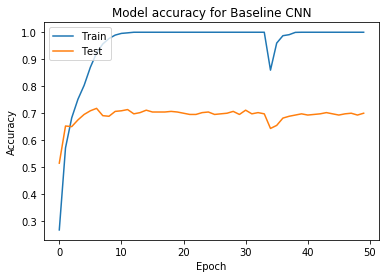

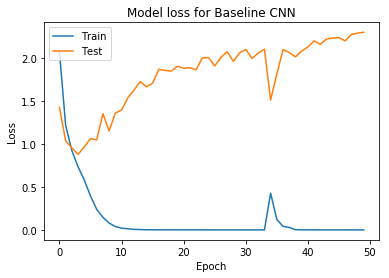

1107/1107 [==============================] - 0s 213us/sample - loss: 1.9623 - acc: 0.7362
Test Accuracy:  0.73622406
Precision, recall, fscore: (0.734054133518046, 0.7362240289069557, 0.7303706651091201, None)


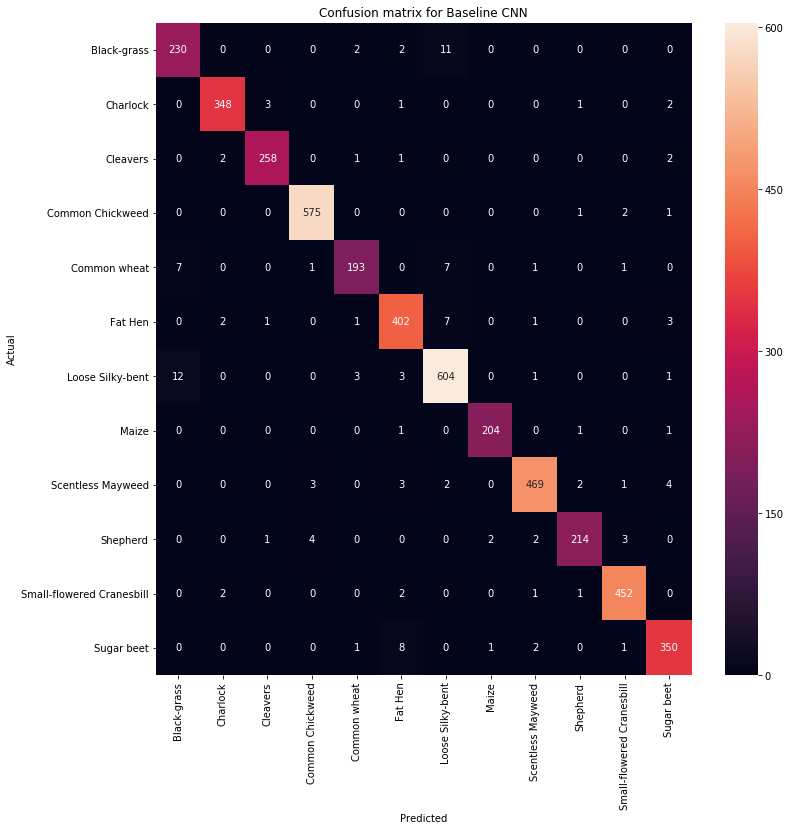

Misclassified examples for  Baseline CNN


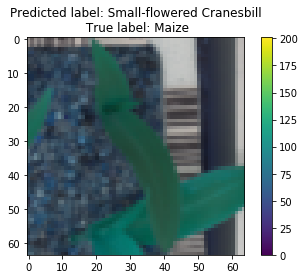

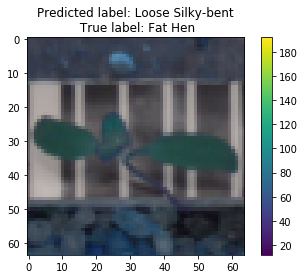

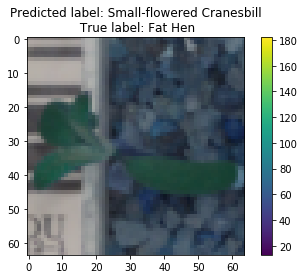

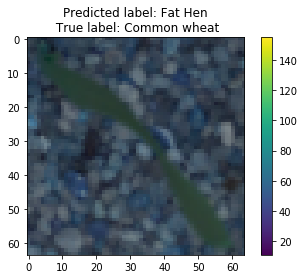

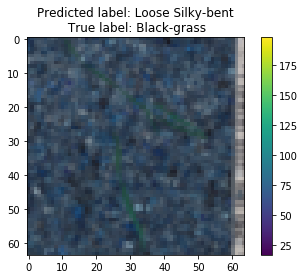

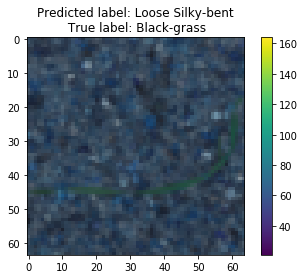

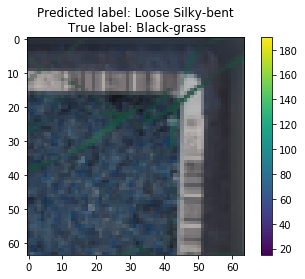

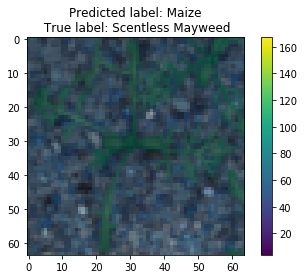

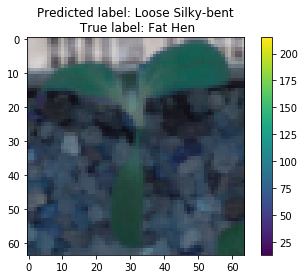

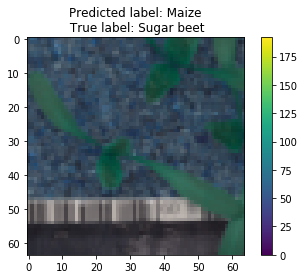

========================== RESULTS FOR DenseNet121 ==========================


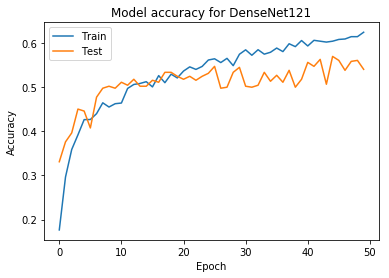

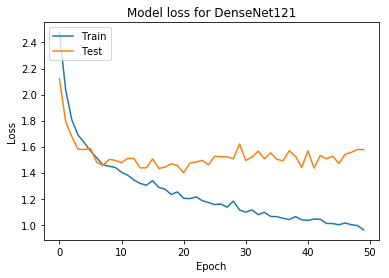

1107/1107 [==============================] - 1s 986us/step
Test Accuracy:  0.5672990065118485
Precision, recall, fscore: (0.5807919003132554, 0.5672990063233966, 0.5694831646749262, None)


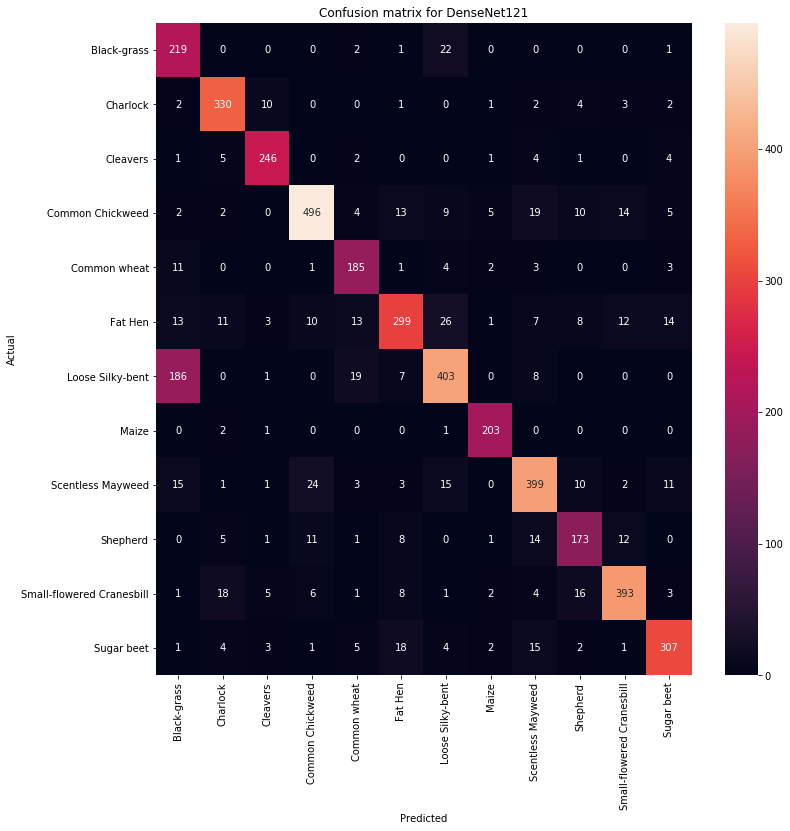

Misclassified examples for  DenseNet121


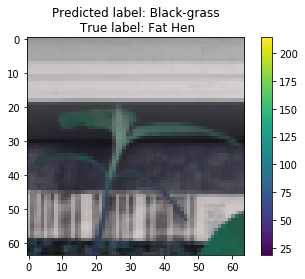

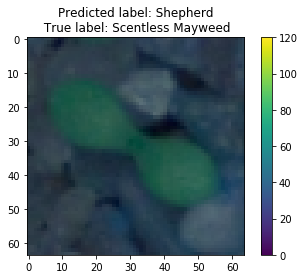

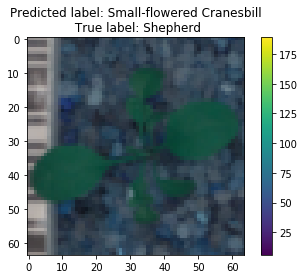

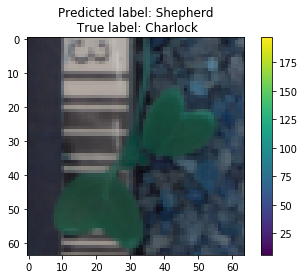

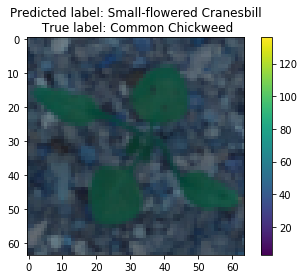

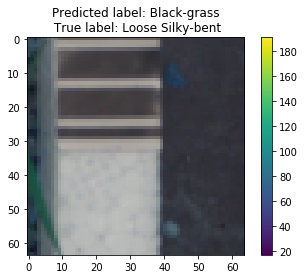

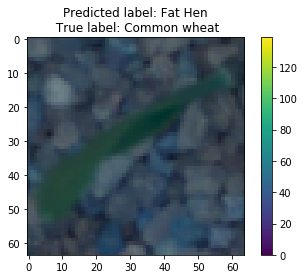

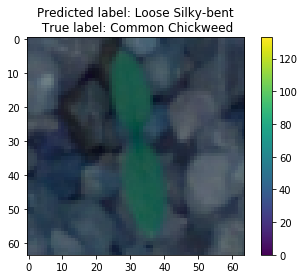

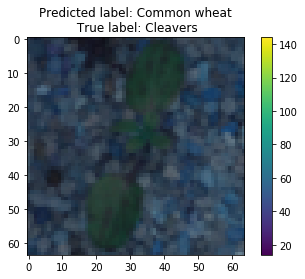

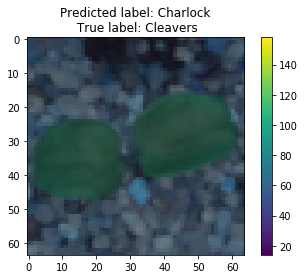

========================== RESULTS FOR VGG16 ==========================


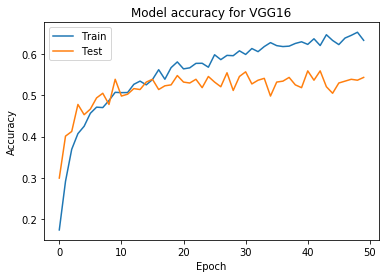

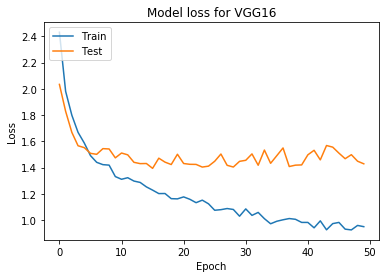

1107/1107 [==============================] - 1s 987us/step
Test Accuracy:  0.594399277110733
Precision, recall, fscore: (0.5996476914481241, 0.5943992773261066, 0.5921683118568086, None)


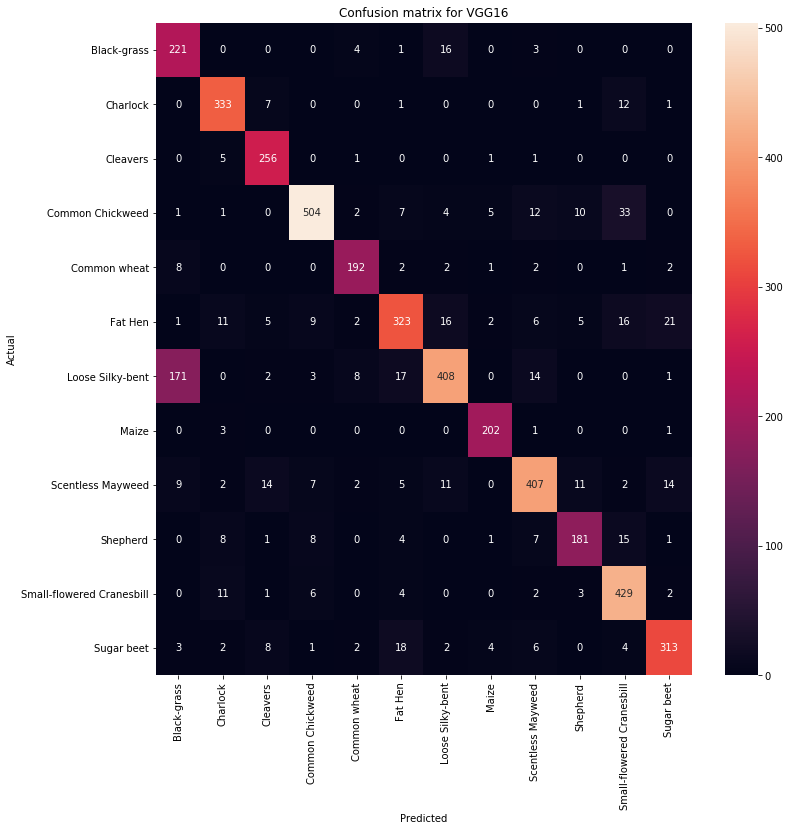

Misclassified examples for  VGG16


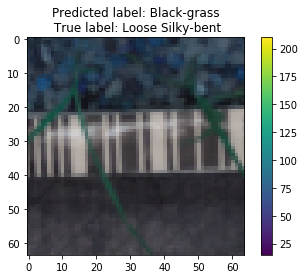

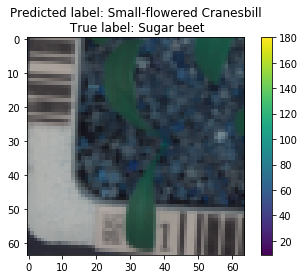

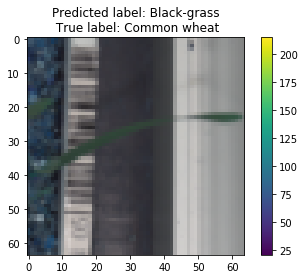

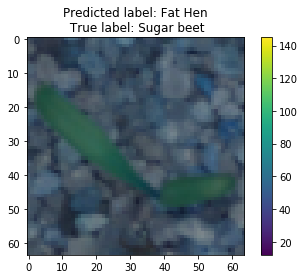

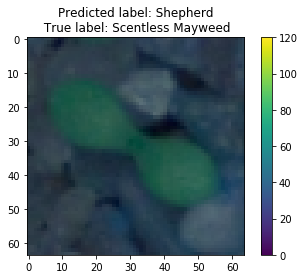

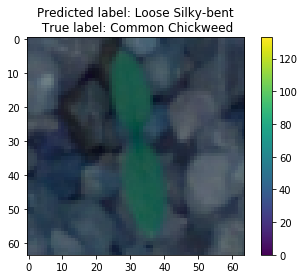

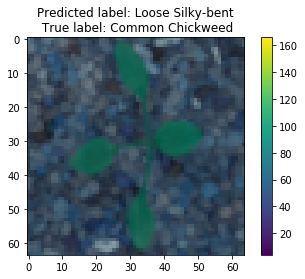

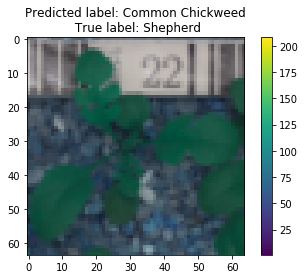

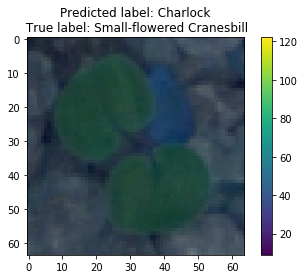

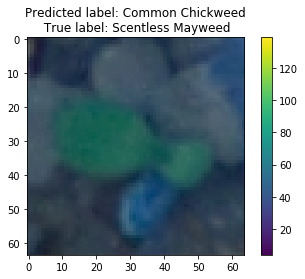

========================== RESULTS FOR ResNet50 ==========================


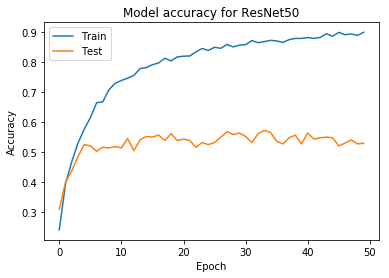

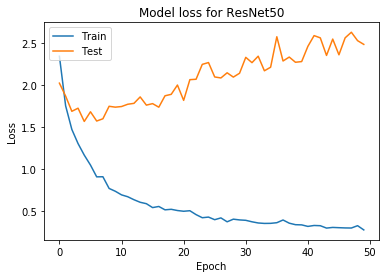

1107/1107 [==============================] - 1s 904us/step
Test Accuracy:  0.569105691379971
Precision, recall, fscore: (0.5676090834475748, 0.5691056910569106, 0.5648980619598155, None)


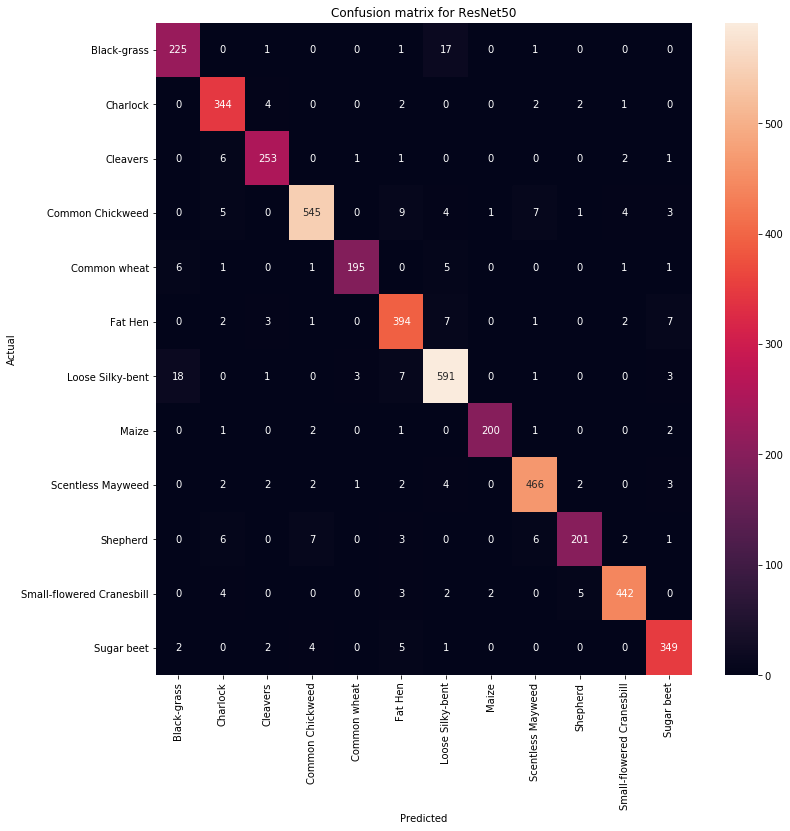

Misclassified examples for  ResNet50


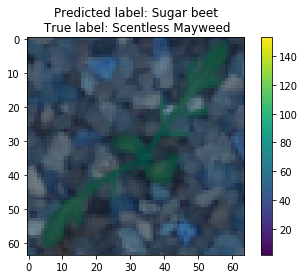

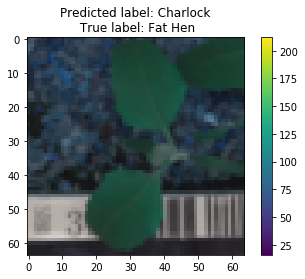

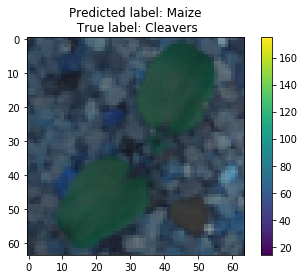

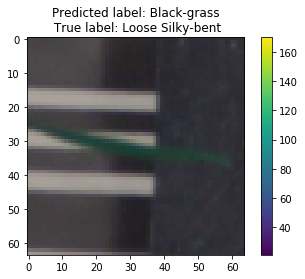

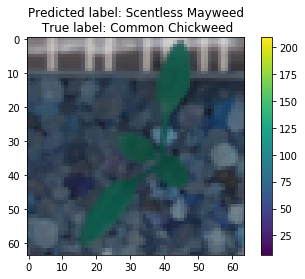

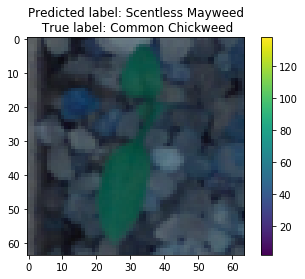

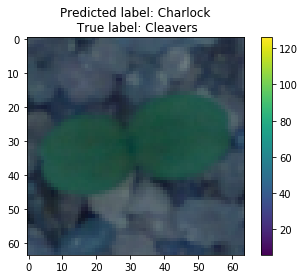

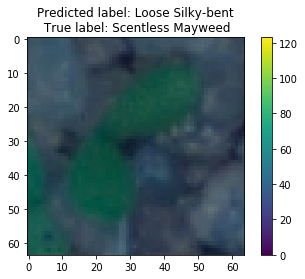

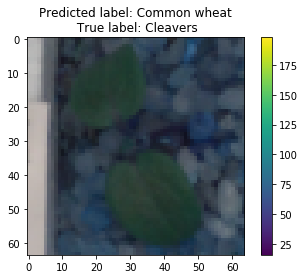

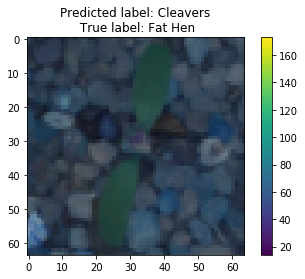

In [102]:
all_models = [("Baseline CNN", cnn_model, cnn_history),
          ("DenseNet121", densenet_model, densenet_history),
          ("VGG16", vgg_model, vgg_history),
          ("ResNet50", resnet_model, resnet_history)]

for title, model, history in all_models:
    print("========================== RESULTS FOR", title, "==========================")
    plot_performance(history, title)
    evaluate_test_accuracy(model, testImages_normed, testLabels_onehot)
    evaluate_f1(model, testImages_normed, testLabels)
    print_conf_matrix(model, trainImages_normed, trainLabels, title)
    
    print("Misclassified examples for ", title)
    show_misclassification_examples(model, testImages_normed, testLabels, 10)
    


# EXPERIMENTS

## Varying number of unfrozen layers in DenseNet121

In [ ]:
all_test_acc = []
all_scores = []

# Try training the model with up to 15 unfrozen layers
num_layers = 15
for i in range(0, num_layers):
    densenet_model = build_densenet(n_freeze_layers=i)
    densenet_history = fit_model(densenet_model, trainImages_normed, trainLabels_onehot)
    
    # Keep track of accuracy and f1 scores for each experiment
    test_acc = evaluate_test_accuracy(densenet_model, testImages_normed, testLabels_onehot)
    test_scores = evaluate_f1(densenet_model, testImages_normed, testLabels)
    all_test_acc.append(test_acc)
    all_scores.append(test_scores)
    


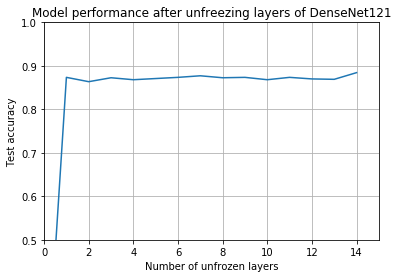

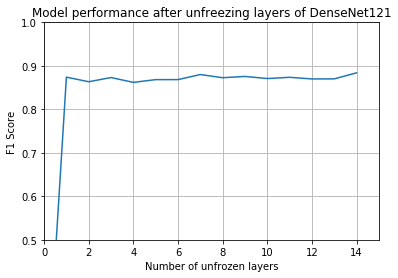

[0.0722673893472905, 0.8735320684924897, 0.8635953028350665, 0.8726287261257327, 0.8681120140227306, 0.8708220413922186, 0.8735320691386105, 0.8771454386056385, 0.8726287261257327, 0.8735320691386105, 0.8681120149380684, 0.8735320691386105, 0.8699186990254617, 0.8690153573048255, 0.8843721768935737]
[0.04783319003676261, 0.8740093238946801, 0.8634688771671715, 0.8731128838694132, 0.8619803724208106, 0.8683154716521285, 0.8683650188811828, 0.8800038324067864, 0.8727026790436118, 0.8756642897614638, 0.8708031498837173, 0.8736627393100731, 0.8698910373947619, 0.870032731647741, 0.883958241625742]
0.8843721768935737
0.883958241625742


In [119]:
# Graph change in test accuracy over number of unfrozen layers
plt.plot(all_test_acc)
plt.xlabel('Number of unfrozen layers')
plt.ylabel('Test accuracy')
plt.title('Model performance after unfreezing layers of DenseNet121')
plt.axis([0, 15, 0.50, 1])
plt.grid(True)
plt.show()

# Extract F1 score from tuple
f1_scores = []
for score in all_scores:
    f1_scores.append(score[2])
    
# Graph change in F1 score over number of unfrozen layers
plt.plot(f1_scores) # plotting by columns
plt.xlabel('Number of unfrozen layers')
plt.ylabel('F1 Score')
plt.title('Model performance after unfreezing layers of DenseNet121')
plt.axis([0, 15, 0.50, 1])
plt.grid(True)
plt.show()

print(all_test_acc)
print(f1_scores)

# Get best performance
print(max(all_test_acc))
print(max(f1_scores))


## More aggressive dropout

In [ ]:
all_test_acc = []
all_scores = []

# Try training the model with increasing dropout rate

for i in np.linspace(0.1,0.9,9):
    densenet_model = build_densenet(n_freeze_layers=1, dropout_rate=i)
    densenet_history = fit_model(densenet_model, trainImages_normed, trainLabels_onehot)
    
    # Keep track of accuracy and f1 scores for each experiment
    test_acc = evaluate_test_accuracy(densenet_model, testImages_normed, testLabels_onehot)
    test_scores = evaluate_f1(densenet_model, testImages_normed, testLabels)
    all_test_acc.append(test_acc)
    all_scores.append(test_scores)

In [134]:
print(np.linspace(0.1,0.9,9))

[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
